<div>
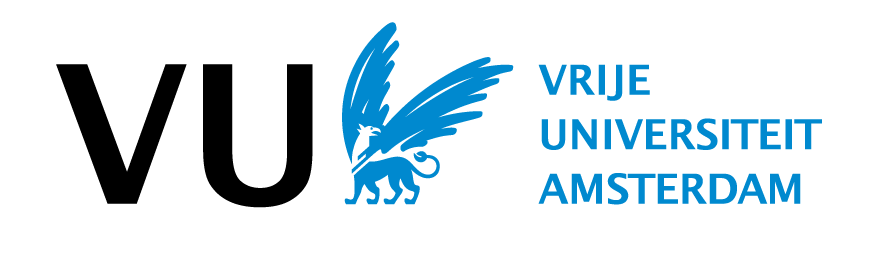
</div>

### Gridap day at "Groupe Calcul"

# Hello world!

## Solving the Poisson eq. with Gridap

by Francesc Verdugo (VU Amsterdam)

2022-12-01

## Contents

We will learn:

- Main steps of a FEM computation in Gridap
- In serial and in parallel


## Example

Solve a 3D Poisson equation with Dirichlet and Neumann boundaries.

$$
\left\lbrace
\begin{aligned}
-\Delta u = f  \ &\text{in} \ \Omega,\\
u = g \ &\text{on}\ \Gamma_{\rm D},\\
\nabla u\cdot n = t \ &\text{on}\  \Gamma_{\rm N},\\
\end{aligned}
\right.
$$


## Numerical scheme

We consider a standard FEM.

Find $u\in U_h$ such that $ a(u,v) = b(v) $ for all $v\in V_h$

$$
  a(u,v) \doteq \int_{\Omega} \nabla v \cdot \nabla u \ {\rm d}\Omega, \quad \ell(v) \doteq \int_{\Omega} v\ f  \ {\rm  d}\Omega + \int_{\Gamma_{\rm N}} v\ t \ {\rm d}\Gamma_{\rm N}.
$$



## Read a mesh from Gmsh

In [ ]:
using Gridap
using GridapGmsh

In [ ]:
msh_file = joinpath(@__DIR__,"toy_model.msh")
model = GmshDiscreteModel(msh_file)

In [ ]:
writevtk(model,"model")

<div>
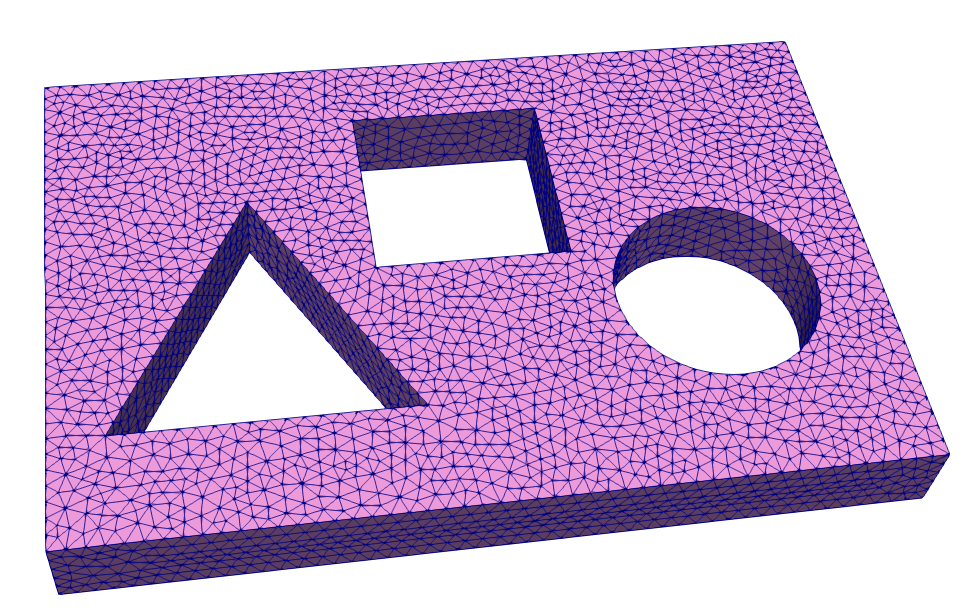
</div>

## Inspect labels

<div>
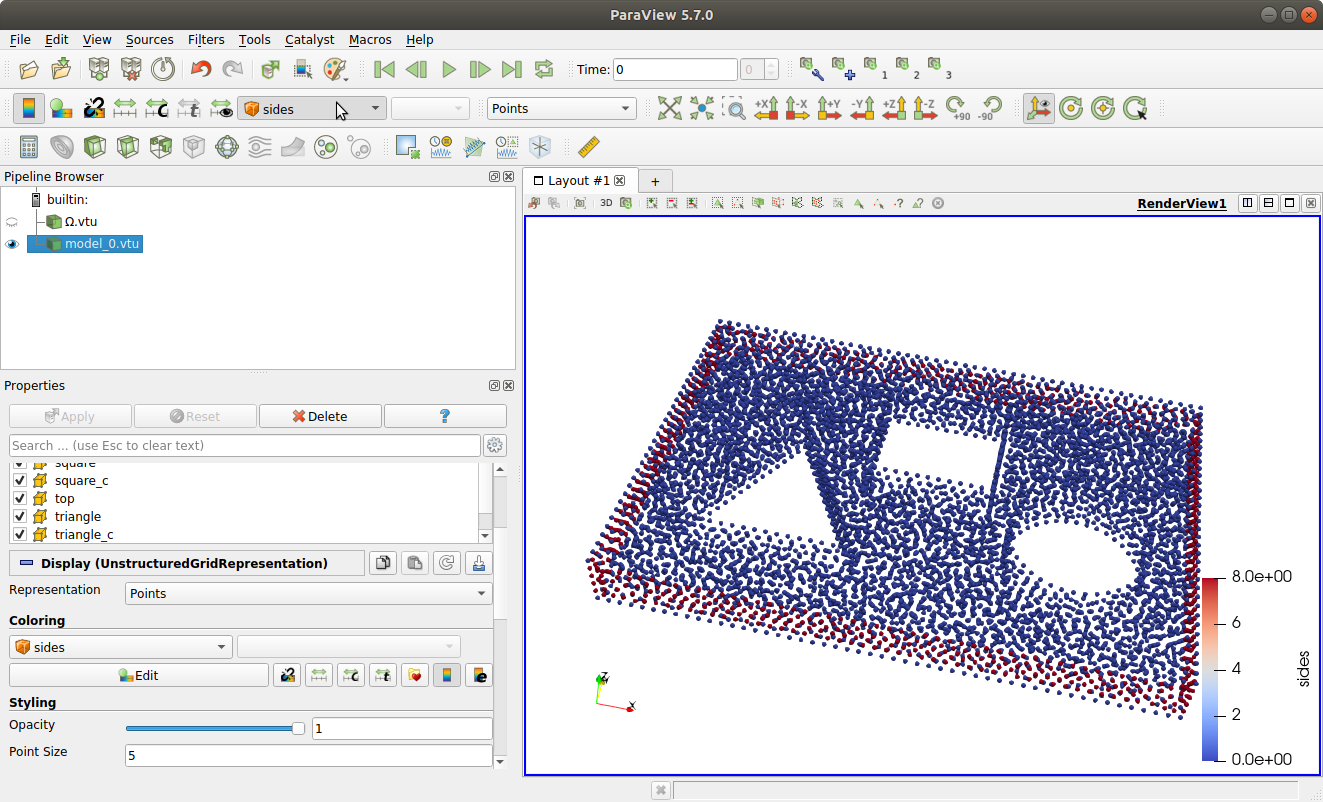
</div>

## Computational domain $\Omega$

In [ ]:
Ω = Interior(model,tags="volume")

In [ ]:
writevtk(Ω,"Ω")

## Neumann boundary $\Gamma_{\rm N}$

In [ ]:
neumann_tags = ["circle", "triangle", "square"]
Γ = Boundary(model,tags=neumann_tags)

In [ ]:
writevtk(Γ,"Γ")



<div>
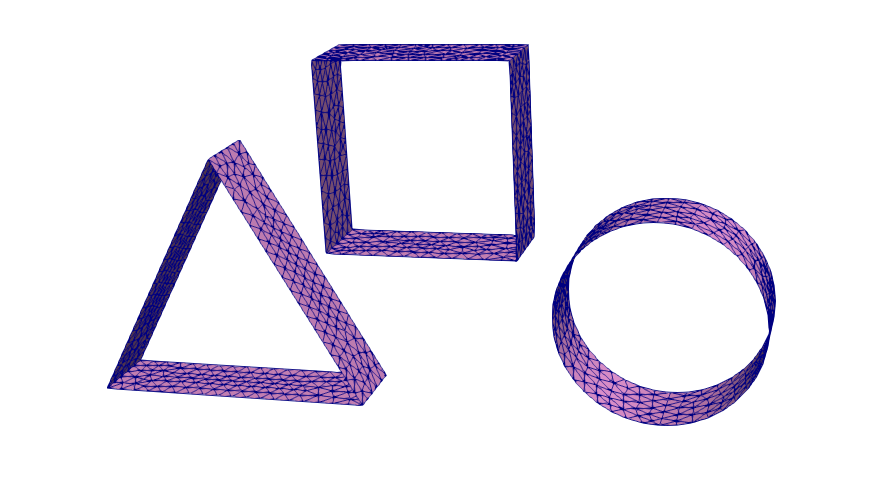
</div>

## FE space

In [ ]:
k = 1
reffe = ReferenceFE(lagrangian,Float64,k)
Vh = TestFESpace(Ω,reffe,dirichlet_tags="sides")

## Visualizing the FE space

In [ ]:
x = rand(num_free_dofs(Vh))
vh_rand = FEFunction(Vh,x)

In [ ]:
writevtk(Ω,"Ω",cellfields=["vh_rand"=>vh_rand])


<div>
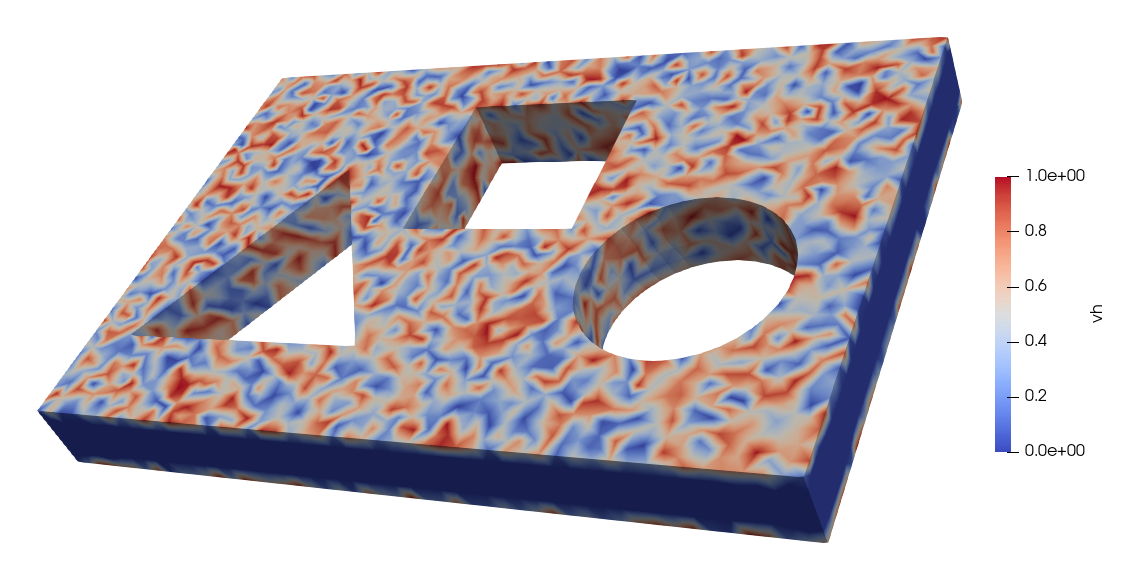
</div>

## Trial FE space

In [ ]:
g(x) = sum(x)

In [ ]:
Uh = TrialFESpace(Vh,g)

In [ ]:
uh_rand = FEFunction(Uh,x)

In [ ]:
writevtk(Ω,"Ω",cellfields=["vh_rand"=>vh_rand,"uh_rand"=>uh_rand])


<div>
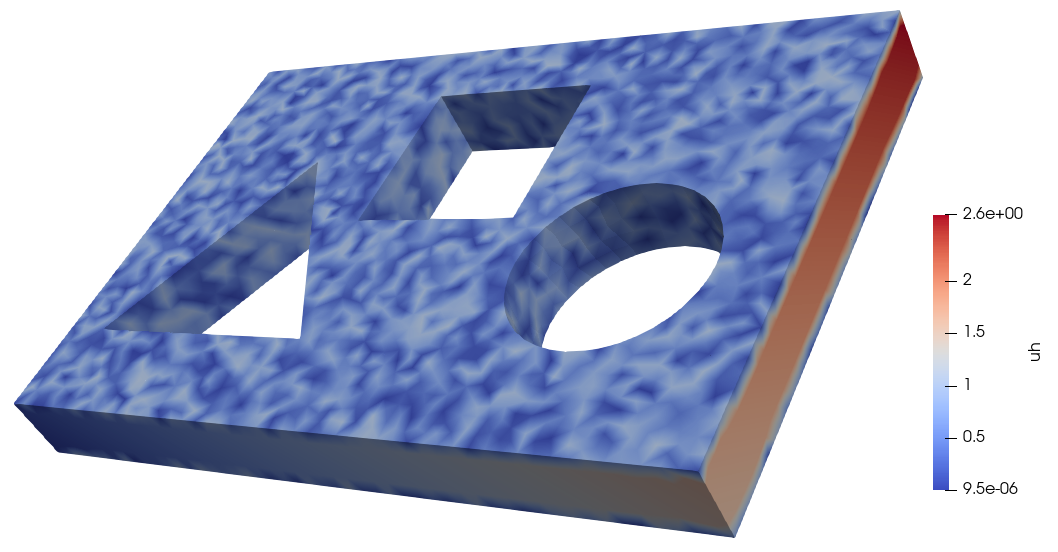
</div>

## Weak form

$$
  a(u,v) \doteq \int_{\Omega} \nabla v \cdot \nabla u \ {\rm d}\Omega, \quad \ell(v) \doteq \int_{\Omega} v\ f  \ {\rm  d}\Omega + \int_{\Gamma_{\rm N}} v\ t \ {\rm d}\Gamma_{\rm N}.
$$


In [ ]:
f(x) = 2
t(x) = 2*x[1]+x[2]

In [ ]:
dΩ = Measure(Ω,2*k)
dΓ = Measure(Γ,2*k)

In [ ]:
a(u,v) = ∫( ∇(u)⋅∇(v) )*dΩ
ℓ(v) = ∫(v*f)*dΩ + ∫(v*t)*dΓ

## FE Assembly

In [ ]:
op = AffineFEOperator(a,ℓ,Uh,Vh)

In [ ]:
A = get_matrix(op)

In [ ]:
b = get_vector(op)

## FE solution 

In [ ]:
uh = solve(op)

In [ ]:
writevtk(Ω,"Ω",cellfields=["uh"=>uh,"vh_rand"=>vh_rand,"uh_rand"=>uh_rand])


<div>
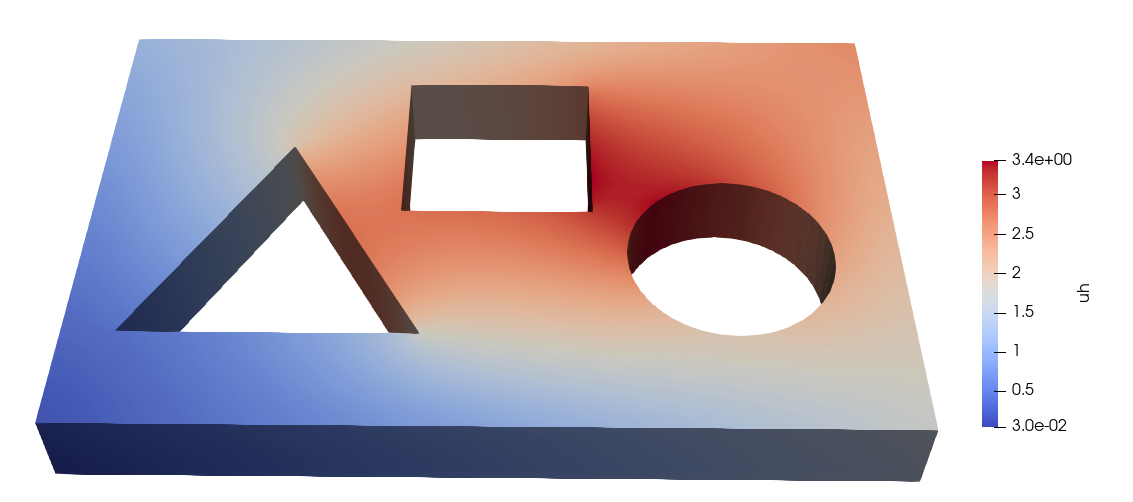
</div>


## Some post-process

In [ ]:
n = get_normal_vector(Γ)
contribs = ∫( abs2(Δ(uh)+f) )*dΩ + ∫( abs2(n⋅∇(uh)-t) )*dΓ

In [ ]:
cell = 1000
contribs[Ω][cell]

In [ ]:
face = 100
contribs[Γ][face]

In [ ]:
writevtk(Ω,"Ω",celldata=["res"=>contribs[Ω]],cellfields=["uh"=>uh,"vh_rand"=>vh_rand,"uh_rand"=>uh_rand])

<div>
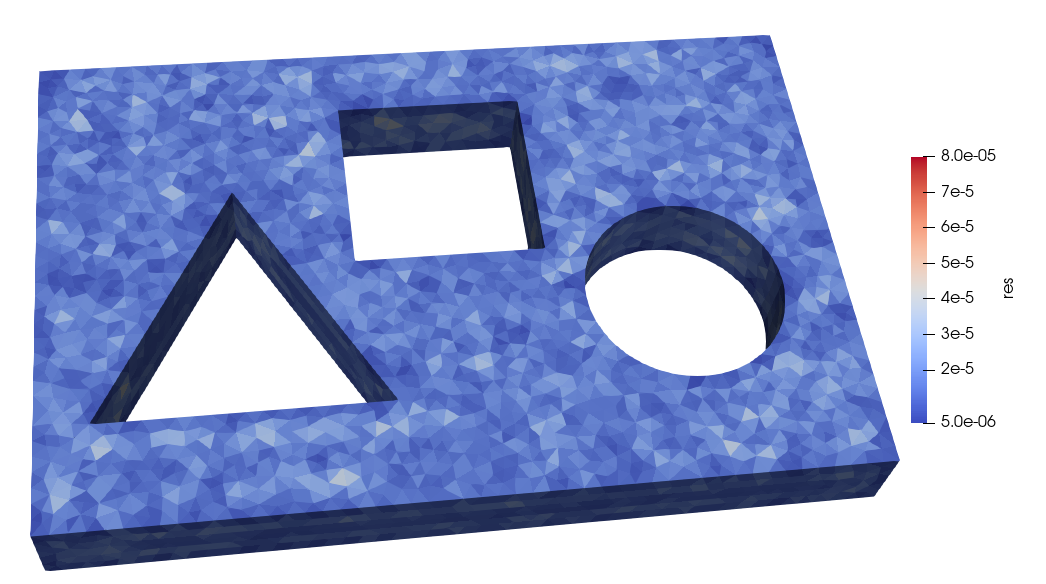
</div>


In [ ]:
writevtk(Γ,"Γ",celldata=["res"=>contribs[Γ]])

<div>
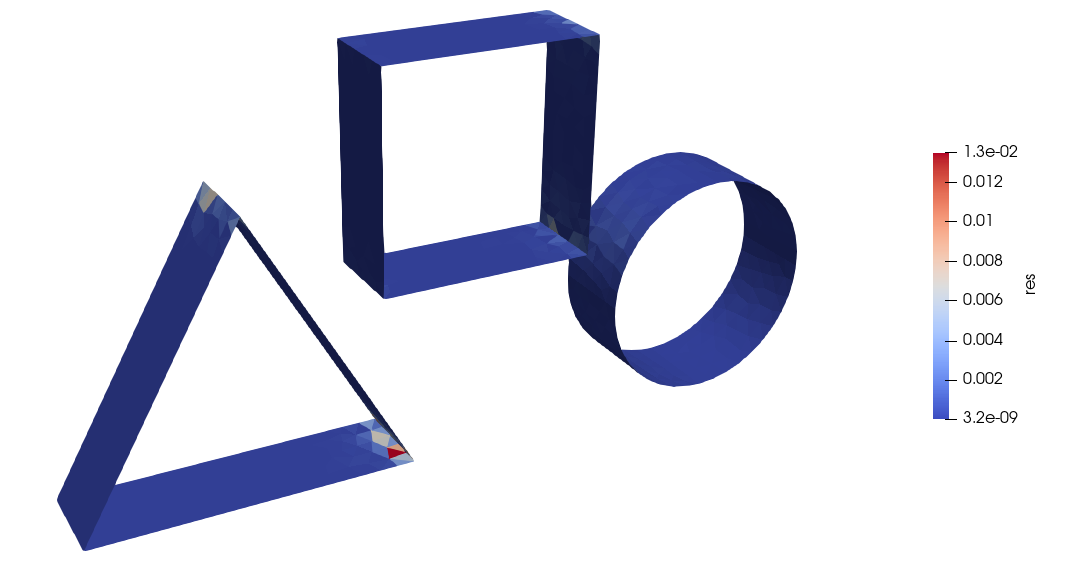
</div>


## Local cell matrix and vector

In [ ]:
dv = get_fe_basis(Vh)
contribs = ℓ(dv)

In [ ]:
cell = 1000
contribs[Ω][cell]

In [ ]:
print_op_tree(contribs[Ω])

In [ ]:
face = 100
contribs[Γ][face]

In [ ]:
du = get_trial_fe_basis(Uh)
contribs = a(du,dv)

In [ ]:
cell = 1000
contribs[Ω][cell]

## Parallel extension

In [ ]:
using GridapDistributed
using PartitionedArrays

In [ ]:
backend = SequentialBackend()
nparts = 4
parts = get_part_ids(backend,nparts)

## Distributed mesh

In [ ]:
msh_file = joinpath(@__DIR__,"toy_model.msh")
model = GmshDiscreteModel(parts,msh_file)

In [ ]:
writevtk(model,"model");


<div>
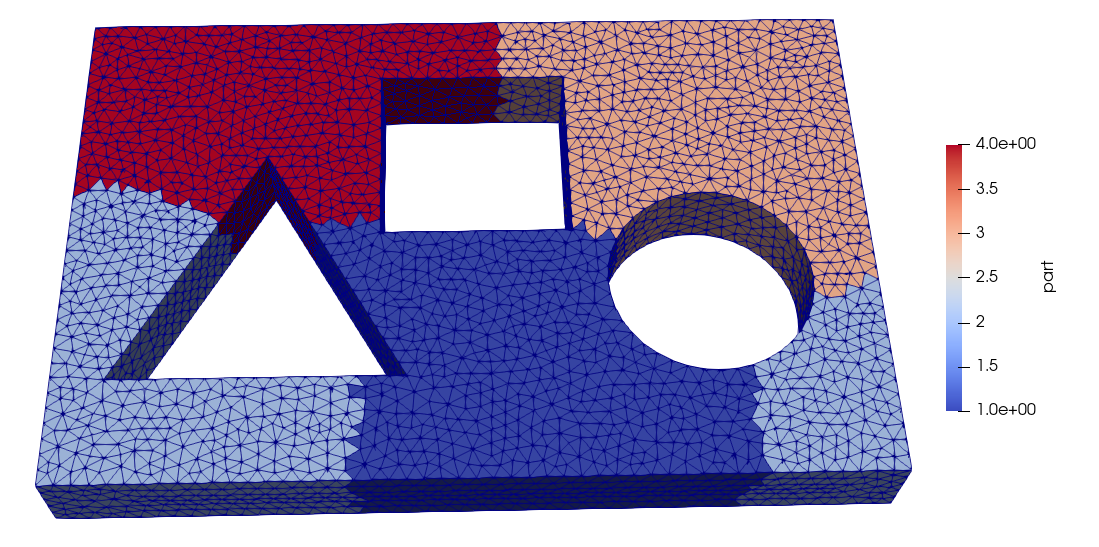
</div>



## Parallel user code $\approx$ serial user code

In [ ]:
Ω = Interior(model,tags="volume")
writevtk(Ω,"Ω");

In [ ]:
neumann_tags = ["circle", "triangle", "square"]
Γ = Boundary(model,tags=neumann_tags)
writevtk(Γ,"Γ");


<div>
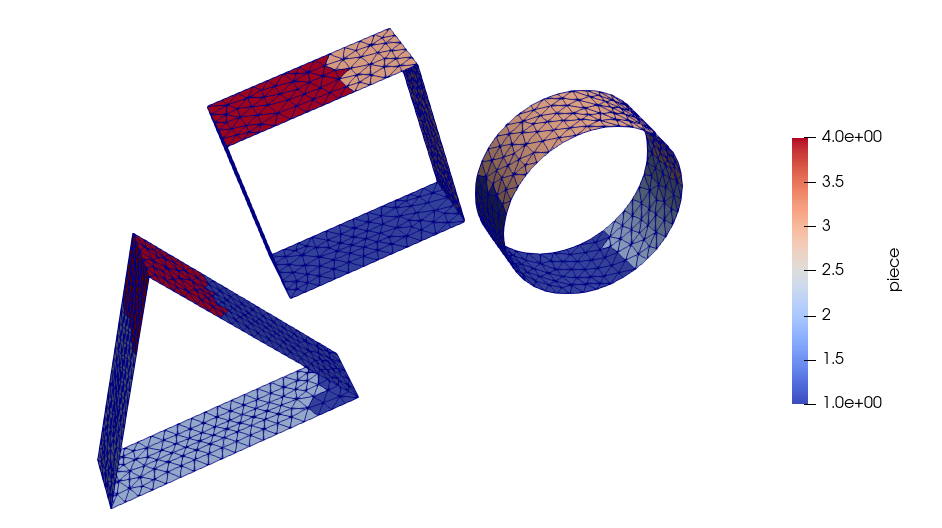
</div>


In [ ]:
k = 1
reffe = ReferenceFE(lagrangian,Float64,k)
Vh = TestFESpace(Ω,reffe,dirichlet_tags="sides")
Uh = TrialFESpace(Vh,g)

In [ ]:
dΩ = Measure(Ω,2*k)
dΓ = Measure(Γ,2*k)
a(u,v) = ∫( ∇(u)⋅∇(v) )*dΩ
ℓ(v) = ∫(v*f)*dΩ + ∫(v*t)*dΓ
op = AffineFEOperator(a,ℓ,Uh,Vh)

In [ ]:
A = get_matrix(op)

In [ ]:
A.values

In [ ]:
uh = solve(op)

In [ ]:
writevtk(Ω,"Ω",cellfields=["uh"=>uh]);

## Parallel sparse linear solvers

In [ ]:
using GridapPETSc

In [ ]:
options = "-pc_type jacobi -ksp_type cg -ksp_converged_reason -ksp_rtol 1.0e-12";

In [ ]:
uh = GridapPETSc.with(args=split(options)) do
    solver = PETScLinearSolver()
    solve(solver,op)
end

In [ ]:
writevtk(Ω,"Ω",cellfields=["uh"=>uh]);

## Low-level linear solver API

In [ ]:
using GridapPETSc.PETSC

In [ ]:
uh, niters = GridapPETSc.with(args=split(options)) do
    A = get_matrix(op)
    b = get_vector(op)
    c = similar(b,axes(A,2))
    solver = PETScLinearSolver()
    ss = symbolic_setup(solver,A)
    ns = numerical_setup(ss,A)
    solve!(c,ns,b)
    uh = FEFunction(Uh,c)
    ksp = ns.ksp
    iter = Ref{PetscInt}()
    PETSC.KSPGetIterationNumber(ksp[],iter)
    uh, iter[]
end

## Timing parallel code

In [ ]:
timer = PTimer(parts)
tic!(timer)
sleep(2)
toc!(timer,"sleep")
timer

In [ ]:
uh = GridapPETSc.with(args=split(options)) do
    solver = PETScLinearSolver()
    tic!(timer)
    solve(solver,op)
    toc!(timer,"Solver")
end
timer

In [ ]:
timer.data

In [ ]:
using FileIO

In [ ]:
map_main(timer.data) do data
   save("times.jld2",data)
end;

In [ ]:
load("times.jld2")